### Import libraries and data
First we start with importing of necessary libraries.

In [1]:
import os
os.chdir('.')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import norm, skew, boxcox #for some statistics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#tweaking some default pandas options
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

Now let's import the dataset and check basic information.

### Quick data check

In [2]:
df = pd.read_csv('./input/diabetes.csv')
print(df.head())
print(df.info())
print(df.describe())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 28.100                     0.167   21        0
4            0      137             40             35      168 43.100                     2.288   33        1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressu

### Data Cleaning and Exploration

Next, let's count 0/Nan.

In [3]:
zero_cl = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[zero_cl] = df[zero_cl].replace(0, np.NaN)
##get count of zero values
print(df.isnull().sum())
print(df.isnull().sum()/768)

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64
Pregnancies                0.000
Glucose                    0.007
BloodPressure              0.046
SkinThickness              0.296
Insulin                    0.487
BMI                        0.014
DiabetesPedigreeFunction   0.000
Age                        0.000
Outcome                    0.000
dtype: float64


Inspect data distribution to hangle Nan properly. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f83b5ad1460>,
      dtype=object)

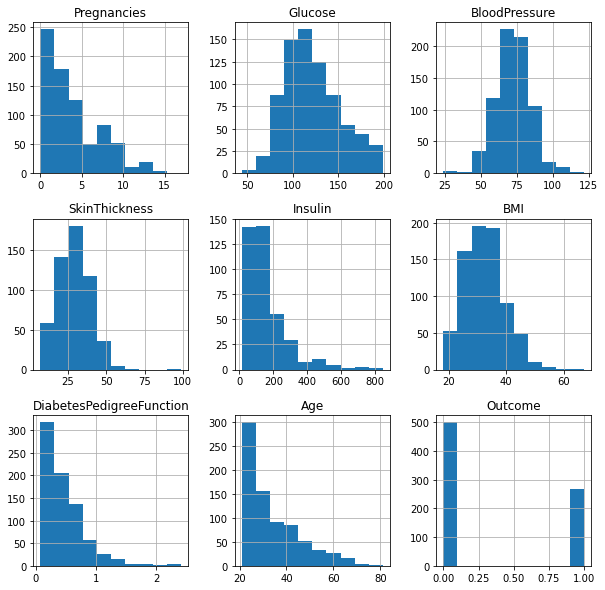

In [4]:
df.hist(figsize = (10,10))

Input missing values.  
Glucose and Blook Pressure are normally distributed - mean will be inputed. 
Skin thickness and BMI are skewed - median will be inputed.
Insulin has almost 50% of Nan. Although it could provide insightfoul information about diabetes Nan is too high and it will be dropped.

In [5]:
df['Glucose'] = df['Glucose'].fillna(df.groupby('Outcome')['Glucose'].transform('mean'))
df['BloodPressure'] = df['BloodPressure'].fillna(df.groupby('Outcome')['BloodPressure'].transform('mean'))
df['SkinThickness'] = df['SkinThickness'].fillna(df.groupby('Outcome')['SkinThickness'].transform('median'))
#df['Insulin'] = df['Insulin'].fillna(df.groupby('Outcome')['Insulin'].transform('median'))
df['BMI'] = df['BMI'].fillna(df.groupby('Outcome')['BMI'].transform('median'))
df.drop(['Insulin'], axis=1, inplace=True)

Now it's time to check relation between features and how separable is the outcome.

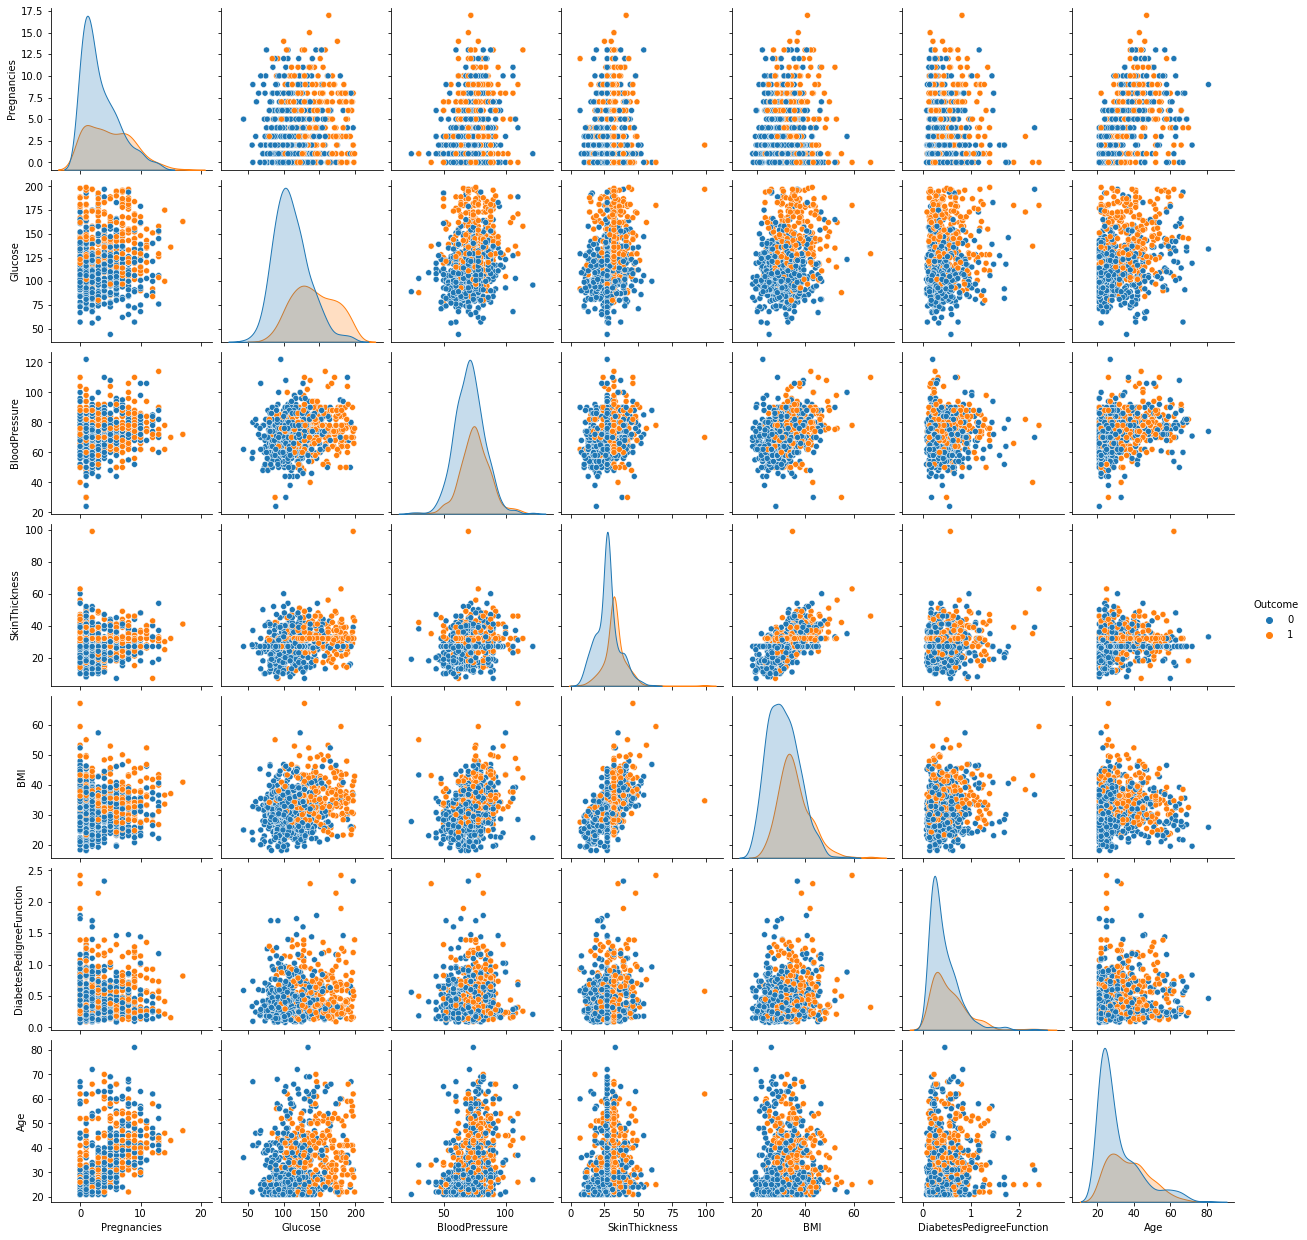

In [6]:
g = sns.pairplot(data=df, hue="Outcome", dropna=True)
plt.show()

Glucose and Skin Thickness seem to be the features that separate the outcome the best. 

Preparation of some plotting functions.  
First let's plot distributions of dependent variables.

/home/ing3lo/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ing3lo/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ing3lo/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

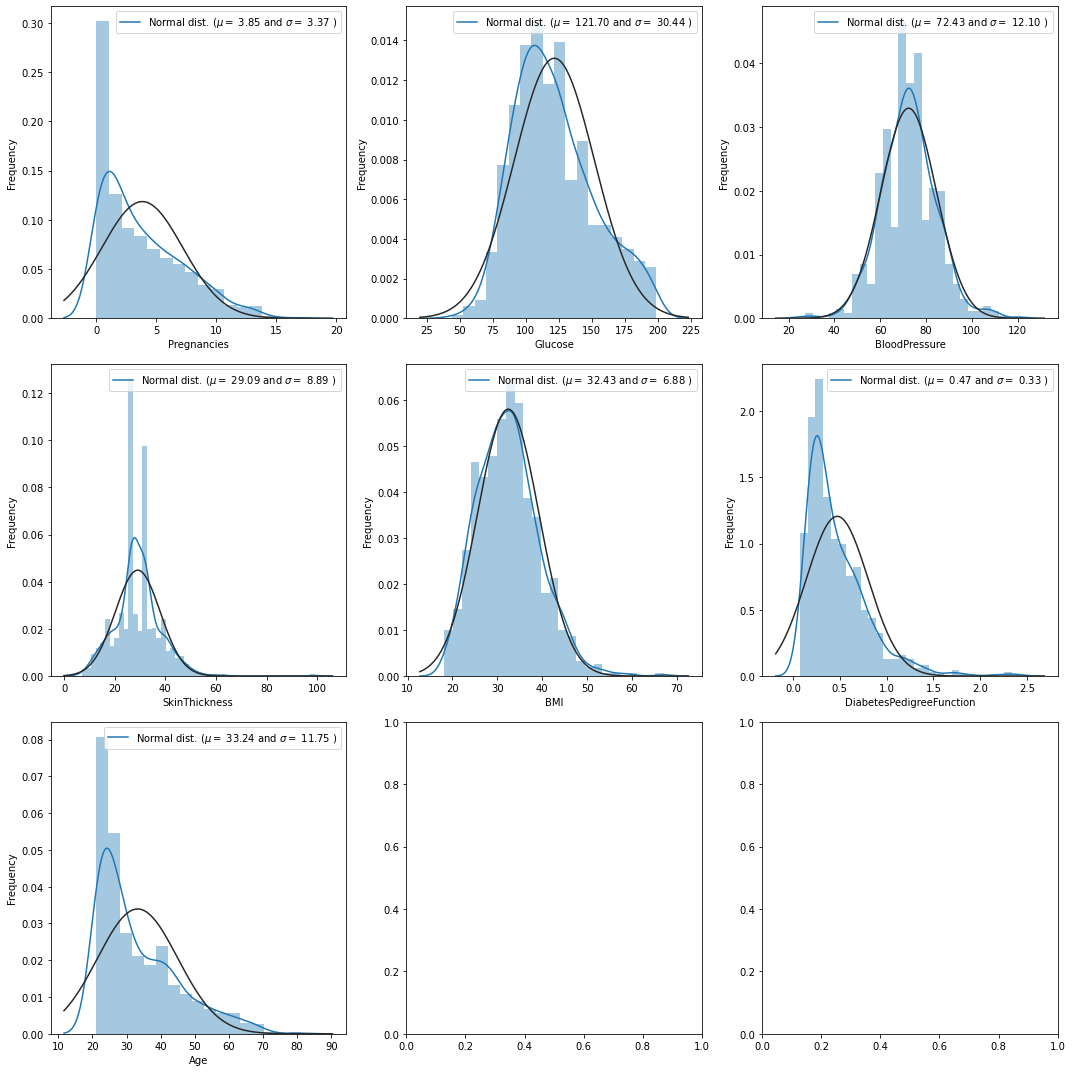

In [7]:
df_X =df.loc[:, df.columns != 'Outcome']

def PlotDist(df):
    fig, axs = plt.subplots(3, 3, figsize=(15,15))
    x1, y1 = 0, 0
    for cl in df.columns:
        #print(cl, x1, y1)
        sns.distplot(df[cl], fit=norm, ax=axs[y1][x1])
        (mu, sigma) = norm.fit(df[cl])
        #Now plot the distribution
        axs[y1][x1].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                    loc='best')
        axs[y1][x1].set_ylabel('Frequency')
        x1 += 1
        if x1 == 3: x1 = 0; y1 +=1
    fig.tight_layout()
PlotDist(df_X)

Most distribtuions are similar either to normal or exponential distribution.  
Skin thickness and insulin distributions have two distinct peaks that are probably dictated by different outcome categories.

Let's compare distributions between the outcome.

/home/ing3lo/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/ing3lo/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


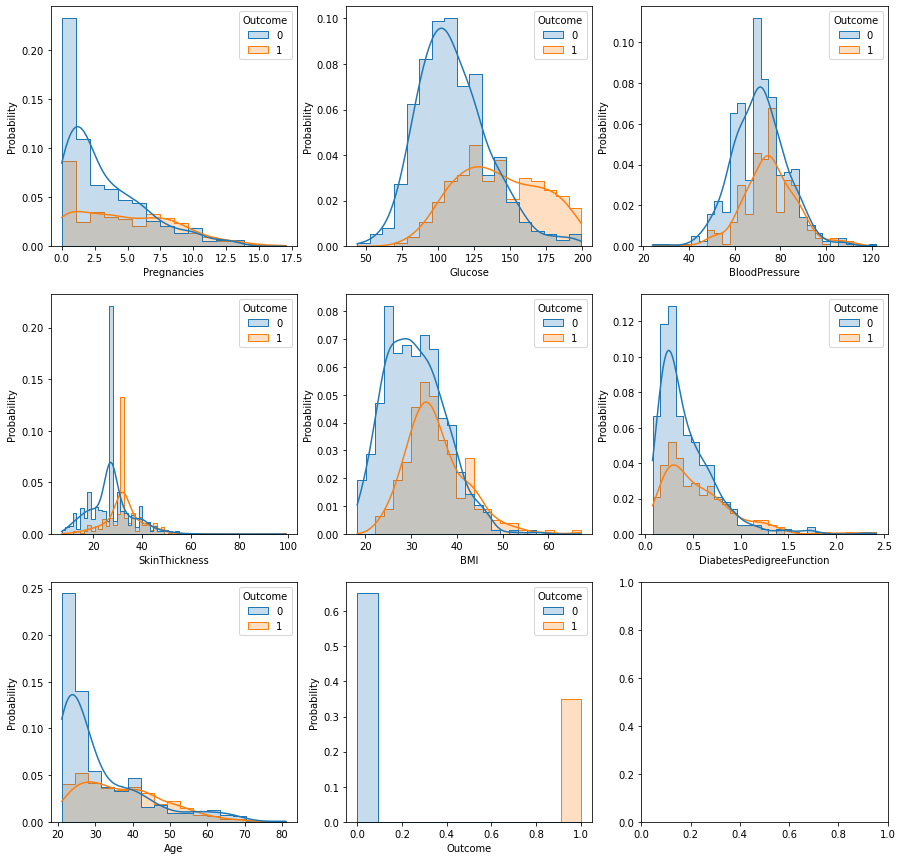

In [8]:
def PlotDistDiff(df):
    fig, axs = plt.subplots(3, 3, figsize=(15,15))
    x1, y1 = 0, 0
    for cl in df.columns:
        #print(cl, x1, y1)
        sns.histplot(df, x=cl, hue='Outcome', stat='probability',
                    multiple='layer', element='step', kde='True', ax=axs[y1][x1])
        axs[y1][x1].set_ylabel('Probability')
        x1 += 1
        if x1 == 3: x1 = 0; y1 +=1
            
PlotDistDiff(df)

The features for which the biggest differences in distrubtion can be observed is feature with two peaks: skin thickness. Also glucose can be useful.  
It has to be stated that high number of samples at the peak bins for Skin Thickness comes from missing data inputation.

Plot box-plots to find possible outliers.

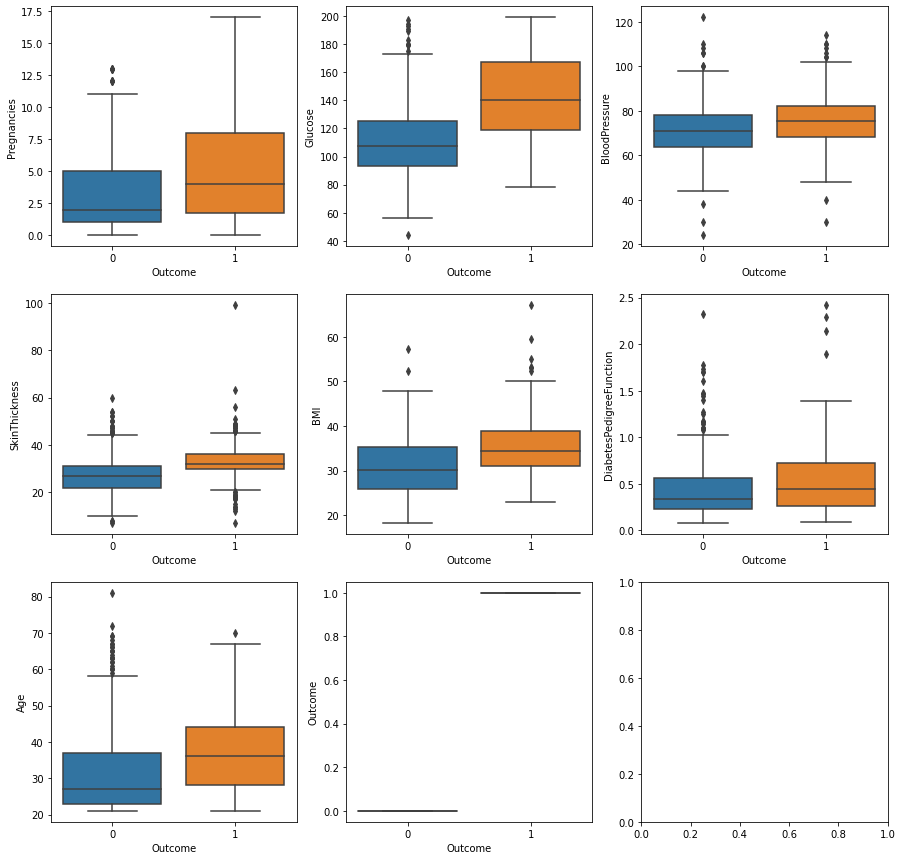

In [9]:
def PlotBox(df):
    fig, axs = plt.subplots(3, 3, figsize=(15,15))
    x1, y1 = 0, 0
    for cl in df.columns:
        #print(cl, x1, y1)
        sns.boxplot(x='Outcome', y=cl, data=df, ax=axs[y1][x1])
        axs[y1][x1].set_ylabel(cl)
        x1 += 1
        if x1 == 3: x1 = 0; y1 +=1
PlotBox(df)

Many outliers can be observed, but they are mostly due to the non-normal distrubtion of features.

Finally, let's check Pearsons correalation parameter between the features.

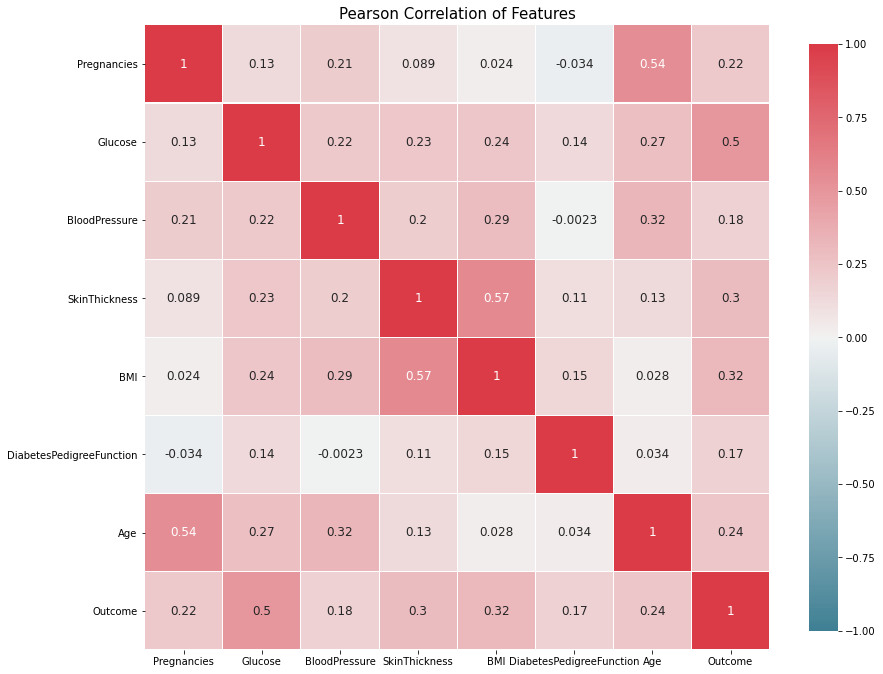

In [10]:
#%% Heatmap of data
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmin = -1.0, vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
correlation_heatmap(df)

### Bottom line

In [11]:
print('Bottom line for test that predict all outcomes as non-' \
      'diabetic is: {:.2f}'.format(df['Outcome'].value_counts()[0]/df['Outcome'].count()))

Bottom line for test that predict all outcomes as non-diabetic is: 0.65


### Train-test split

In [12]:
#Split data
ran = 33
print("Random state: ", ran)
X = df.loc[:, df.columns != 'Outcome']
y = df.loc[:, df.columns == 'Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=ran)

Random state:  33


### Logistic regression  

In [13]:
#Logistic regression with l_2 regularization and standard scaling
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

standard = StandardScaler()
pipe_lr = Pipeline(steps=[('s', standard),('lr', LogisticRegression(max_iter=10000, penalty='l2'))])
params = {
 'lr__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10., 100., 1000., 10000]
     }
#cv = StratifiedKFold(n_splits=10)
grid_search = GridSearchCV(pipe_lr, scoring='f1',
                           param_grid = params, return_train_score =True, n_jobs = 8, cv=10)
grid_search.fit(X_train, y_train.values.ravel())

print('Grid search score, train data: {:.3f}'.format(grid_search.best_score_))
#Not bad but let's check recall and precision
print("Best params.")
print(grid_search.best_params_)
lr=grid_search.best_estimator_
y_pred = grid_search.predict(X_test)
print('Logistic regression. Test data.')
print('Accuracy score is: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score is: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Recall score is: {:.3f}'.format(recall_score(y_test, y_pred)))
print('F1 score is: {:.3f}'.format(f1_score(y_test, y_pred)))
print('ROC_AUC score is: {:.3f}'.format(roc_auc_score(y_test, y_pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

Grid search score, train data: 0.639
Best params.
{'lr__C': 1.0}
Logistic regression. Test data.
Accuracy score is: 0.745
Precision score is: 0.714
Recall score is: 0.500
F1 score is: 0.588
ROC_AUC score is: 0.693
Confusion matrix:
[[108  14]
 [ 35  35]]


Minimization of false negatives (finding all diabetes) is more important than false positives (falsely indicating that someone has diabates who is healthy). So the recall could be boosted by moving of decision boundary.  
Let's first check how the plot in log(odds) space look like.

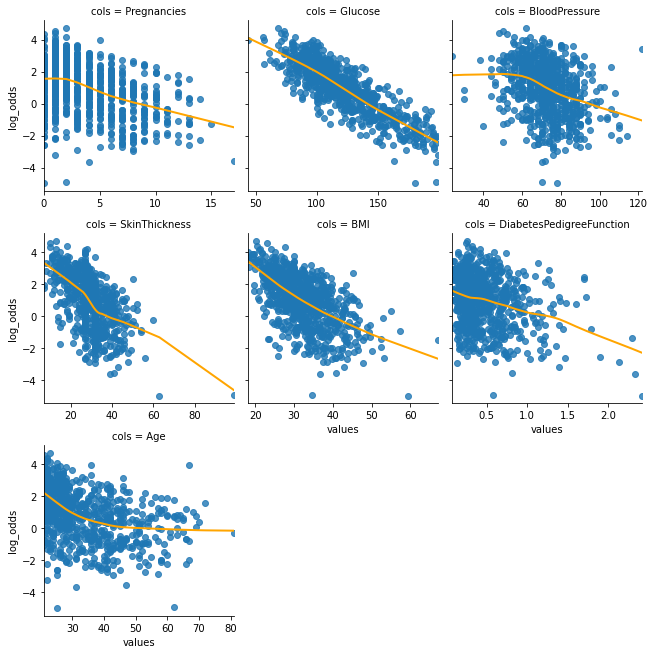

In [14]:
def PlotLogit(df, lr):
    df_f = df.loc[:, df.columns != 'Outcome']
    prob = lr.predict_proba(X)
    df_f['log_odds'] = np.log(prob[:,0]/prob[:,1])
    df_fm = df_f.melt('log_odds', var_name='cols',  value_name='values')
    sns.lmplot(x='values', y='log_odds', data=df_fm, col='cols', col_wrap=3, 
               height=3, lowess=True, sharex=False, line_kws={'lw': 2, 'color': 'orange'})
PlotLogit(df, grid_search)

Logit functions seem sufficiently linear for most of the features. Blood pressure could be removed.

Now, it is time to check the influential values.

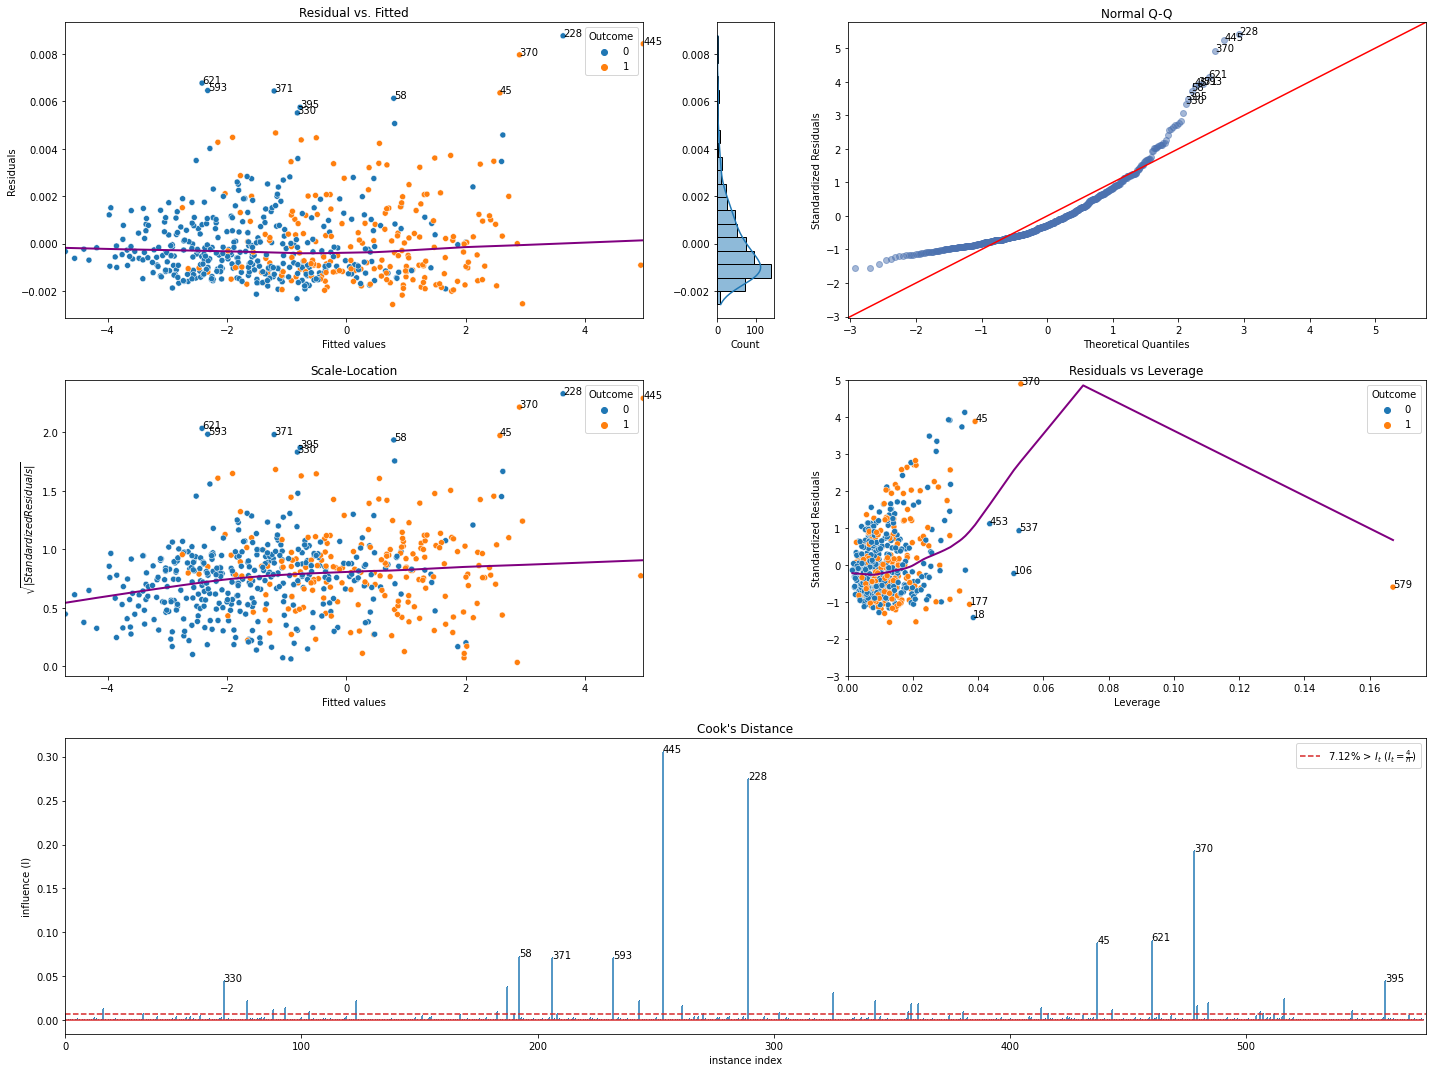

In [15]:
import sciplot #plotting function have been gathered into a separate library
import importlib #just for reimports in case of doing changes in library
importlib.reload(sciplot)
diag = sciplot.Diagnostic(X_train, y_train, lr, lr['lr'].C)
fig = diag.plotDiagnostic(10)

Distribution is rightly-skewed as Q-Q plot indicates.
Let's remove 15 biggest value of Cook's distance and leverage.

Deleting entries with index:  Int64Index([228, 445, 370, 621, 593, 371, 45, 58, 395, 330], dtype='int64')
Deleting entries with index:  Int64Index([579, 537, 106, 453, 18, 177, 459, 13, 464, 39], dtype='int64')


(<Figure size 1440x1080 with 6 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f83b36536d0>])

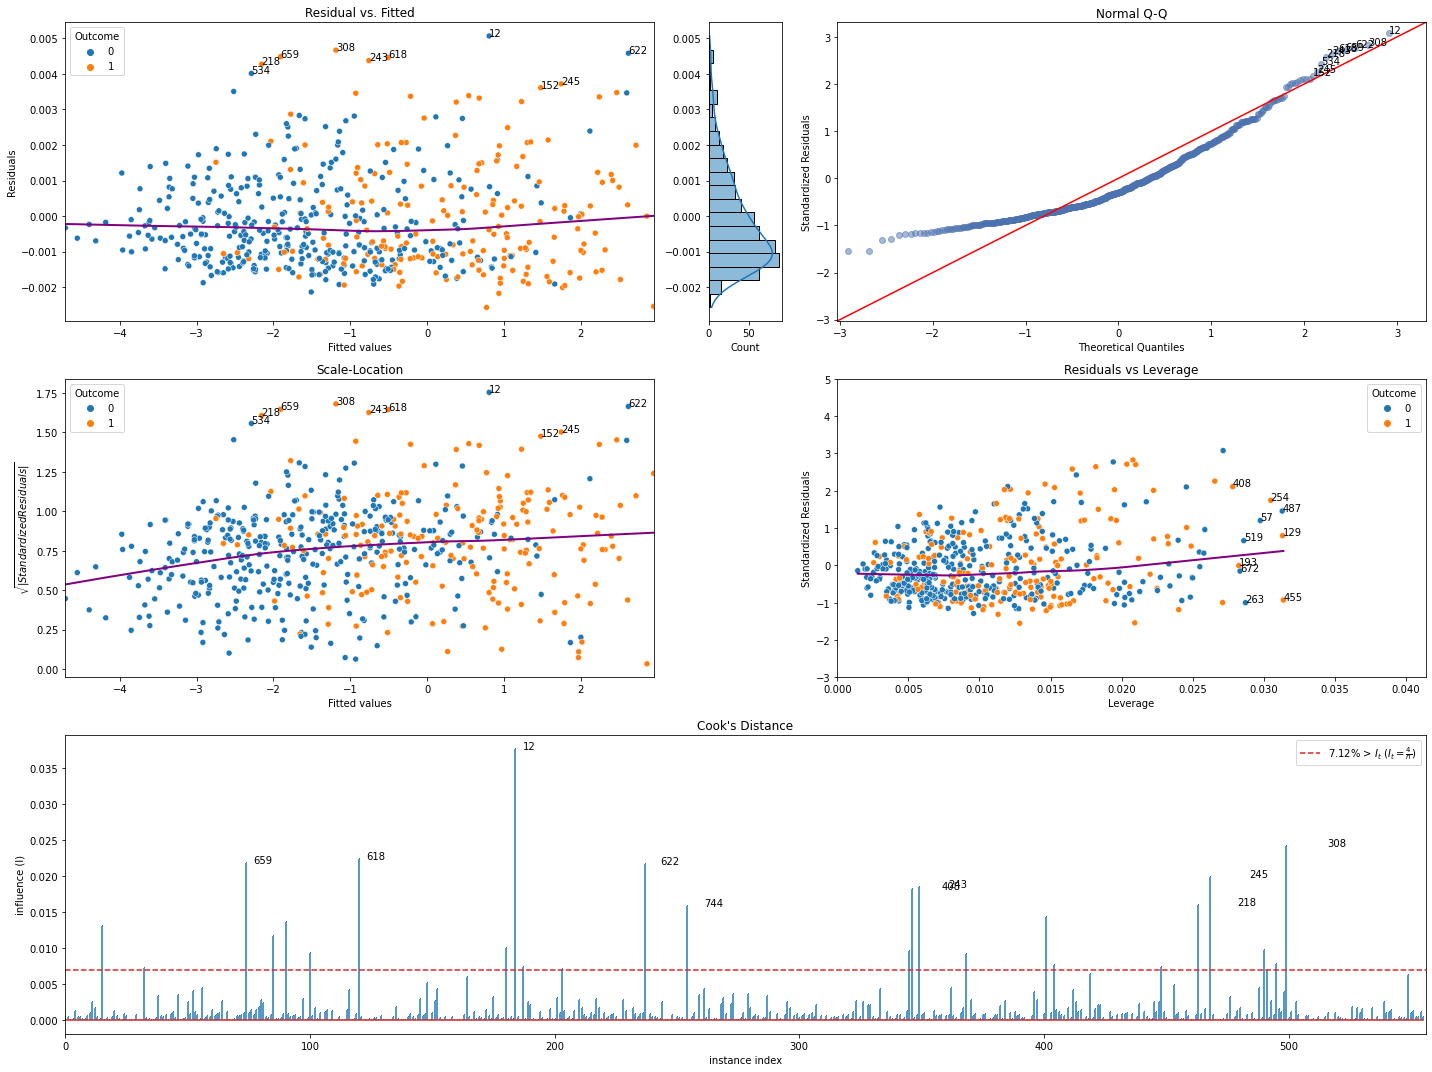

In [16]:
diag.removeMax(type='residual', number=10)
diag.removeMax(type='leverage', number=10)
diag.plotDiagnostic(10)

Let's fit the model with removed data again and check if it improved.  

In [17]:
X_trainR, y_trainR = diag.returnData()
pipe_lr = Pipeline(steps=[('s', standard),('lr', LogisticRegression(max_iter=10000, penalty='l2'))])
params = {
 'lr__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10., 100., 1000., 10000]
     }
grid_search = GridSearchCV(pipe_lr, scoring='f1',
                           param_grid = params, return_train_score =True, n_jobs = 8, cv=10)
grid_search.fit(X_trainR, y_trainR.values.ravel())
print('Grid search score, train data: {:.3f}'.format(grid_search.best_score_))
#Not bad but let's check recall and precision
print("Best params.")
print(grid_search.best_params_)
lr=grid_search.best_estimator_
y_pred = lr.predict(X_test)
print('Logistic regression. Test data.')
print('Accuracy score is: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score is: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Recall score is: {:.3f}'.format(recall_score(y_test, y_pred)))
print('F1 score is: {:.3f}'.format(f1_score(y_test, y_pred)))
print('ROC_AUC score is: {:.3f}'.format(roc_auc_score(y_test, y_pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

Grid search score, train data: 0.642
Best params.
{'lr__C': 1.0}
Logistic regression. Test data.
Accuracy score is: 0.745
Precision score is: 0.706
Recall score is: 0.514
F1 score is: 0.595
ROC_AUC score is: 0.696
Confusion matrix:
[[107  15]
 [ 34  36]]


Recall and roc_auc have improved slightly at a cost of precision. It seem that more advanced models could give better performance.  
Let's inspect regression coefficients.

In [18]:
pd.DataFrame([X_train.columns, lr[1].coef_.T]).T

,0,1
0,Pregnancies,[0.4033685575405309]
1,Glucose,[1.1077579633469234]
2,BloodPressure,[-0.06695915392962186]
3,SkinThickness,[0.34344133445648767]
4,BMI,[0.3940466567880323]
5,DiabetesPedigreeFunction,[0.3297332790052169]
6,Age,[0.12996998236937582]


As predicted the most influential parameter is glucose. Blood pressure which has distributions almost on the top of each other has negative coefficient.  
Finally let's check for multicolinearity.

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
XX = StandardScaler().fit_transform(X_train)
#to keep intercept small values have to be of the same order
X_trainC = add_constant(StandardScaler().fit_transform(X_train))
cols = np.concatenate([['intercept'], X_train.columns.values])
print(pd.Series([variance_inflation_factor(X_trainC, i) 
               for i in range(X_trainC.shape[1])], 
              index=cols))

intercept                  1.000
Pregnancies                1.397
Glucose                    1.187
BloodPressure              1.290
SkinThickness              1.515
BMI                        1.659
DiabetesPedigreeFunction   1.049
Age                        1.619
dtype: float64


Results are below 5-10 threshold so no multicolinearity occurs.

Let's see if recall can be boosted at the cost of precision.

<ipython-input-20-670bdcefee9a>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


Text(0, 0.5, 'Recall')

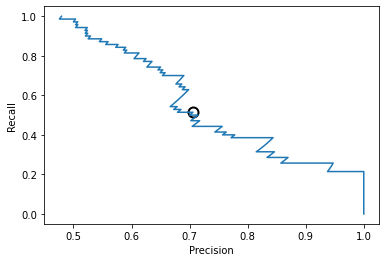

In [20]:
#%% let's see if recall can be boosted
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, lr.decision_function(X_test))
ax = plt.subplot(111)
ax = plt.subplot(111)
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")

Average precision: 0.757
AUC: 0.838


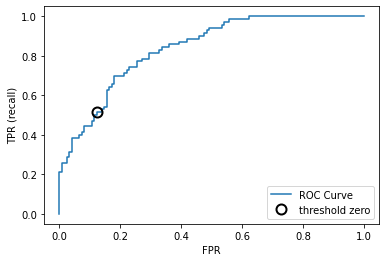

In [21]:
from sklearn.metrics import average_precision_score
print("Average precision: {:.3f}".format(average_precision_score(y_test, lr.predict_proba(X_test)[:, 1])))

#%% Receiver operating point (ROC) and area under the curve (AUC)
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, lr.decision_function(X_test))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

print("AUC: {:.3f}".format(roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])))

Recall could be boosted by almost 20% with only slight increase of False Positive Rate. For now we leave and we check how other models perform.  

### k-Nearest Neighbours Classifier

In [22]:
#%% kNN Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer

def nothing(X):
    return X
#Let's try different data transformation
transformers = [('raw', FunctionTransformer(nothing)), ('MinMaxScaler', MinMaxScaler()),
                ('StandardScaler', StandardScaler()), ('RobustScaler', RobustScaler())]

params = {
 'kn__n_neighbors': np.arange(1,20)
     }
gs_list = []

for (name, trans) in transformers:
    knn_pipe = Pipeline(steps=[(name, trans),('kn', KNeighborsClassifier())])
    grid_search = GridSearchCV(knn_pipe, scoring='f1',
                               param_grid = params, return_train_score =True, n_jobs = 8)
    grid_search.fit(X_train, y_train.values.ravel())
    print('Preprocessing: {:s}, train data: {:.3f}'.format(name, grid_search.best_score_))
    print(grid_search.best_params_)
    gs_list.append(grid_search)

Preprocessing: raw, train data: 0.666
{'kn__n_neighbors': 9}
Preprocessing: MinMaxScaler, train data: 0.624
{'kn__n_neighbors': 19}
Preprocessing: StandardScaler, train data: 0.648
{'kn__n_neighbors': 5}
Preprocessing: RobustScaler, train data: 0.654
{'kn__n_neighbors': 7}


Best performance obtained is with a robust scaler.

In [23]:
knn = gs_list[3].best_estimator_
y_pred = knn.predict(X_test)
print('Accuracy score is: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score is: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Recall score is: {:.3f}'.format(recall_score(y_test, y_pred)))
print('F1 score is: {:.3f}'.format(f1_score(y_test, y_pred)))
print('ROC_AUC score is: {:.3f}'.format(roc_auc_score(y_test, y_pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

Accuracy score is: 0.750
Precision score is: 0.683
Recall score is: 0.586
F1 score is: 0.631
ROC_AUC score is: 0.715
Confusion matrix:
[[103  19]
 [ 29  41]]


Gives slightly better performance for f1-score and recall but has worse precision.

### Naive Bayes
It assumes normal data distribution of independent variables so transformation will have to be applied.

In [24]:
#%% Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_val_score

transformers = [('raw', FunctionTransformer(nothing)), 
                ('QuantileTransformer', QuantileTransformer(output_distribution='normal')),
                ('StandardScaler', StandardScaler())]

pipe_list = []
for (name, trans) in transformers:
    gnb_pipe = Pipeline(steps=[(name, trans),('gnb', GaussianNB())])
    pipe_list.append(gnb_pipe)
    scores = cross_val_score(gnb_pipe, X_train, y_train, cv=5, scoring='f1', n_jobs = 8)
    print('Transformation: {:s}, cross-val mean: {:.3f}, \
          cross-val std: {:.3f}'.format(name, scores.mean(), scores.std()))

Transformation: raw, cross-val mean: 0.644,           cross-val std: 0.019
Transformation: QuantileTransformer, cross-val mean: 0.698,           cross-val std: 0.041
Transformation: StandardScaler, cross-val mean: 0.644,           cross-val std: 0.019


Quantile transformation yields the best results.

In [25]:
gnb = pipe_list[1].fit(X_test, y_test.values.ravel())
y_pred = gnb.predict(X_test)
print('Accuracy score is: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score is: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Recall score is: {:.3f}'.format(recall_score(y_test, y_pred)))
print('F1 score is: {:.3f}'.format(f1_score(y_test, y_pred)))
print('ROC_AUC score is: {:.3f}'.format(roc_auc_score(y_test, y_pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

Accuracy score is: 0.755
Precision score is: 0.653
Recall score is: 0.700
F1 score is: 0.676
ROC_AUC score is: 0.743
Confusion matrix:
[[96 26]
 [21 49]]


/home/ing3lo/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2367: UserWarning: n_quantiles (1000) is greater than the total number of samples (192). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


Again f1-score and recall have been boosted by a cost of precision.

### Support Vector Machines

In [26]:
from sklearn.svm import SVC

#Let's again compare different scaling methods
params = {
 'svc__C': np.geomspace(0.0001, 1000, num=8),
 'svc__gamma': [0.00001, 0.0001, 0.0002, 0.0005, 0.001, 0.01, 0.1, 1.0]
     }

for (name, trans) in transformers:
    svc_pipe = Pipeline(steps=[(name, trans), ('svc', SVC())])

    grid_search = GridSearchCV(svc_pipe, scoring='f1',
                               param_grid = params, return_train_score =True, n_jobs = 8)
    grid_search.fit(X_train, y_train.values.ravel())
    print('Preprocessing: {:s}, train data: {:.3f}'.format(name, grid_search.best_score_))
    print(grid_search.best_params_)

Preprocessing: raw, train data: 0.641
{'svc__C': 10.0, 'svc__gamma': 0.0001}


/home/ing3lo/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2367: UserWarning: n_quantiles (1000) is greater than the total number of samples (576). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


Preprocessing: QuantileTransformer, train data: 0.646
{'svc__C': 10.0, 'svc__gamma': 0.01}
Preprocessing: StandardScaler, train data: 0.658
{'svc__C': 10.0, 'svc__gamma': 0.01}


This time the best performance is obtained for standard scaler.

In [27]:
svc = gs_list[2].best_estimator_
y_pred = svc.predict(X_test)
print('Accuracy score is: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score is: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Recall score is: {:.3f}'.format(recall_score(y_test, y_pred)))
print('F1 score is: {:.3f}'.format(f1_score(y_test, y_pred)))
print('ROC_AUC score is: {:.3f}'.format(roc_auc_score(y_test, y_pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

Accuracy score is: 0.729
Precision score is: 0.641
Recall score is: 0.586
F1 score is: 0.612
ROC_AUC score is: 0.699
Confusion matrix:
[[99 23]
 [29 41]]


Results obtained from SVM are worse than kNN and Naive Bayes classification.

### Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

params = {
 'max_features': ['auto', 'sqrt', 4, 6, 8],
 'min_samples_leaf': [1,5,10],
 'max_depth': [1,3,5]
     }

grid_search = GridSearchCV(RandomForestClassifier(n_estimators=500, class_weight='balanced'), 
                           scoring='f1',
                           param_grid = params, return_train_score =True, n_jobs = 8, verbose=1)
grid_search.fit(X_train, y_train.values.ravel())

print('Grid search score, train data: {:.3f}'.format(grid_search.best_score_))
print("Best params.")
print(grid_search.best_params_)
rfc=grid_search.best_estimator_
y_pred = rfc.predict(X_test)
print('Random Forest Classification. Test data.')
print('Accuracy score is: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score is: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Recall score is: {:.3f}'.format(recall_score(y_test, y_pred)))
print('F1 score is: {:.3f}'.format(f1_score(y_test, y_pred)))
print('ROC_AUC score is: {:.3f}'.format(roc_auc_score(y_test, y_pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   21.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 225 out of 225 | elapsed:  1.8min finished


Grid search score, train data: 0.748
Best params.
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1}
Random Forest Classification. Test data.
Accuracy score is: 0.812
Precision score is: 0.724
Recall score is: 0.786
F1 score is: 0.753
ROC_AUC score is: 0.807
Confusion matrix:
[[101  21]
 [ 15  55]]


Random forest classifier outperforms former models.

### Gradient Boosting Classifier

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

params = {
 'learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1],
 'max_features': ['auto', 'sqrt', 4, 6, 8, 10],
 'min_samples_leaf': [1,5,10],
 'max_depth': [1,3,5]
     }

grid_search = GridSearchCV(GradientBoostingClassifier(n_estimators=500), scoring='f1',
                           param_grid = params, return_train_score =True, n_jobs = 8, verbose=1)
grid_search.fit(X_train, y_train)

print('Grid search score, train data: {:.3f}'.format(grid_search.best_score_))
print("Best params.")
print(grid_search.best_params_)
gbc=grid_search.best_estimator_
y_pred = gbc.predict(X_test)
print('Random Forest Classification. Test data.')
print('Accuracy score is: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score is: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Recall score is: {:.3f}'.format(recall_score(y_test, y_pred)))
print('F1 score is: {:.3f}'.format(f1_score(y_test, y_pred)))
print('ROC_AUC score is: {:.3f}'.format(roc_auc_score(y_test, y_pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 200 tasks      | elapsed:   41.6s
[Parallel(n_jobs=8)]: Done 450 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 800 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 1266 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 1350 out of 1350 | elapsed:  5.2min finished
/home/ing3lo/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Grid search score, train data: 0.751
Best params.
{'learning_rate': 0.1, 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 5}
Random Forest Classification. Test data.
Accuracy score is: 0.818
Precision score is: 0.754
Recall score is: 0.743
F1 score is: 0.748
ROC_AUC score is: 0.802
Confusion matrix:
[[105  17]
 [ 18  52]]


Gradient boosted classifier is slightly worse than Random Forest classifier.

### Comparison
Let's sum up different models:

In [30]:
print('\nLogistic Regression:')
y_pred = lr.predict(X_test)
print('Acc: {:.3f}, Prec: {:.3f}, Recall: {:.3f}, F1: {:.3f}'.format(accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))

print('\nkNN:')
y_pred = knn.predict(X_test)
print('Acc: {:.3f}, Prec: {:.3f}, Recall: {:.3f}, F1: {:.3f}'.format(accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))

print('\nGaussian Naive Bayesian:')
y_pred = gnb.predict(X_test)
print('Acc: {:.3f}, Prec: {:.3f}, Recall: {:.3f}, F1: {:.3f}'.format(accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))

print('\nSVM:')
y_pred = svc.predict(X_test)
print('Acc: {:.3f}, Prec: {:.3f}, Recall: {:.3f}, F1: {:.3f}'.format(accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))

print('\nRandom forest tree:')
y_pred = rfc.predict(X_test)
print('Acc: {:.3f}, Prec: {:.3f}, Recall: {:.3f}, F1: {:.3f}'.format(accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))

print('\nGradient-boosted tree:')
y_pred = gbc.predict(X_test)
print('Acc: {:.3f}, Prec: {:.3f}, Recall: {:.3f}, F1: {:.3f}'.format(accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))


Logistic Regression:
Acc: 0.745, Prec: 0.706, Recall: 0.514, F1: 0.595

kNN:
Acc: 0.750, Prec: 0.683, Recall: 0.586, F1: 0.631

Gaussian Naive Bayesian:
Acc: 0.755, Prec: 0.653, Recall: 0.700, F1: 0.676

SVM:
Acc: 0.729, Prec: 0.641, Recall: 0.586, F1: 0.612

Random forest tree:
Acc: 0.812, Prec: 0.724, Recall: 0.786, F1: 0.753

Gradient-boosted tree:
Acc: 0.818, Prec: 0.754, Recall: 0.743, F1: 0.748


The best performance is for Random Forest and Gradient-boosted tree. Let's see if it is possible to boost results by combination of models.

### Voting classifier

In [31]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from itertools import combinations 
#ignore pandas warning about n_quantiles size
import warnings
warnings.filterwarnings('ignore') 


#dataset size is small so we can compare different combinations of models
#and their performance in order to choose the best one
cv = StratifiedKFold(n_splits=5)
models = [('lr', lr), ('knn', knn), ('gnb', gnb), ('svm', svc), ('rfc', rfc), ('gbc', gbc)]
models_names = ['lr', 'knn', 'gnb', 'svm', 'rfc', 'gbc']
combs = []
combs_names = []
for i in np.arange(1, len(models)+1):
    els = [list(x) for x in combinations(models, i)]
    els_names = [list(x) for x in combinations(models_names, i)]
    combs.extend(els)
    combs_names.extend(els_names)
ensemble_res = pd.DataFrame(columns = ['models', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc',])
for i, ens in enumerate(combs):
    # Training classifiers
    eclf = VotingClassifier(estimators=ens, voting='soft')
    scores = cross_validate(eclf, X_train, y_train.values.ravel(), cv=cv, scoring=['accuracy',
                                                    'precision', 'recall', 'f1', 'roc_auc'])
    acc = scores['test_accuracy'].mean()
    prec = scores['test_precision'].mean()
    recall = scores['test_recall'].mean()
    f1 = scores['test_f1'].mean()
    roc_auc = scores['test_roc_auc'].mean()
    ensemble_res.loc[len(ensemble_res)]=[str(combs_names[i]), acc, prec, recall, f1, roc_auc] 

In [32]:
ensemble_res.T
print("\nMax accuracy:")
print(ensemble_res.iloc[ensemble_res['accuracy'].idxmax()])
print("\nMax precision:")
print(ensemble_res.iloc[ensemble_res['precision'].idxmax()])
print("\nMax recall:")
print(ensemble_res.iloc[ensemble_res['recall'].idxmax()])
print("\nMax f1-score:")
print(ensemble_res.iloc[ensemble_res['f1'].idxmax()])
print("\nMax roc_auc:")
print(ensemble_res.iloc[ensemble_res['roc_auc'].idxmax()])


Max accuracy:
models       ['rfc', 'gbc']
accuracy              0.835
precision             0.765
recall                0.753
f1                    0.758
roc_auc               0.899
Name: 20, dtype: object

Max precision:
models       ['svm', 'gbc']
accuracy              0.826
precision             0.775
recall                0.702
f1                    0.734
roc_auc               0.886
Name: 19, dtype: object

Max recall:
models       ['rfc']
accuracy       0.818
precision      0.717
recall         0.778
f1             0.746
roc_auc        0.881
Name: 4, dtype: object

Max f1-score:
models       ['rfc', 'gbc']
accuracy              0.835
precision             0.765
recall                0.753
f1                    0.758
roc_auc               0.899
Name: 20, dtype: object

Max roc_auc:
models       ['gbc']
accuracy       0.832
precision      0.774
recall         0.722
f1             0.746
roc_auc        0.900
Name: 5, dtype: object


(-0.25, 62.25)

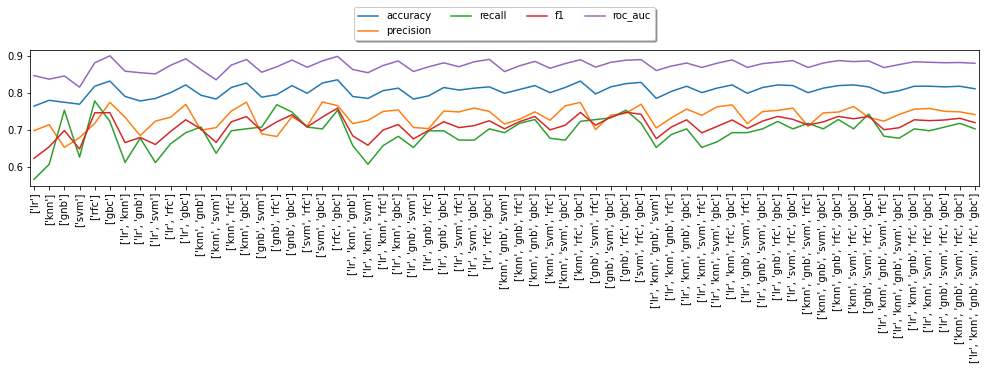

In [33]:
x = ensemble_res['models']
fig, ax = plt.subplots(1,1, figsize=(17,2.5))
ax.plot(x, ensemble_res['accuracy'], label='accuracy')
ax.plot(x, ensemble_res['precision'], label='precision')
ax.plot(x, ensemble_res['recall'], label='recall')
ax.plot(x, ensemble_res['f1'], label='f1')
ax.plot(x, ensemble_res['roc_auc'], label='roc_auc')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=4, fancybox=True, shadow=True)
ax.set_xticklabels(x, rotation='vertical')
ax.set_xlim(-0.25, len(x)-0.75)

Different model combinations result in best performance for different scores. We choose Random Forest with Gradient-boosted classifier since they provide the best performance for our metric: f1-score.

### Final model performance

In [34]:
models = [('rfc', rfc), ('gbc', gbc)]
eclf = VotingClassifier(estimators=models, voting='soft')
eclf.fit(X_train, y_train)
y_pred = eclf.predict(X_test)
print('Voting classifier. Test data.')
print('Accuracy score is: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('Precision score is: {:.3f}'.format(precision_score(y_test, y_pred)))
print('Recall score is: {:.3f}'.format(recall_score(y_test, y_pred)))
print('F1 score is: {:.3f}'.format(f1_score(y_test, y_pred)))
print('ROC_AUC score is: {:.3f}'.format(roc_auc_score(y_test, y_pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

Voting classifier. Test data.
Accuracy score is: 0.839
Precision score is: 0.775
Recall score is: 0.786
F1 score is: 0.780
ROC_AUC score is: 0.827
Confusion matrix:
[[106  16]
 [ 15  55]]
